In [1]:
#!pip3 install yellowbrick

### IMPORTANDO BIBLIOTECAS

In [2]:
import pandas as pd
import numpy as np
import plotly.express as px
import plotly.graph_objects as go
import seaborn as sns

from sklearn.cluster import KMeans
from yellowbrick.cluster import KElbowVisualizer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')

### IMPORTANDO DADOS

In [3]:
jogadores = pd.read_csv('jogadores.csv', sep=',') # Dados dos jogadores
partidas = pd.read_csv('partidas.csv', sep=',') # Dados das partidas

# COMBINANDO DADOS (PARA FACILITAR AGRUPAMENTOS)
dados = partidas.merge(jogadores, how='inner', on='player_id')

# DELETANDO DFs QUE NÃO SERÃO MAIS UTILIZADOS (LIBERAR MEMORIA)
del partidas

### AGRUPANDO DADOS E CRIANDO NOVAS VARIAVEIS

In [4]:
# TOTAL DE PARTIDAS DISPUTADAS POR JOGADOR + TOTAL DE GOLS + TEMPO TOTAL JOGADO
base = dados.groupby(['player_id']).agg({'gols_marcados':'sum','tempo_partida':'sum','partida_id': pd.Series.nunique})
base.rename(columns={'tempo_partida':'tempo_total','partida_id':'partidas'}, inplace=True)

# GRAVANDO PARTIDAS E TEMPO/JOGADOR NA BASE DE JOGADORES
jogadores = jogadores.merge(base, how='left', on='player_id', copy=False)

# MEDIA GOLS POR PARTIDA
jogadores['med_gols_partida'] = (jogadores['gols_marcados'] / jogadores['partidas']).round(2)

# QTD VITORIAS/EMPATES/DERROTAS
status = {'V':'vitorias', 'E':'empates','D':'derrotas'}

for item, status_name in status.items():
    base = dados[dados['status'] == item]
    base = base.groupby(['player_id'])['status'].count().reset_index(name=status_name)
    jogadores = jogadores.merge(base, how='left', on='player_id', copy=False) #GRAVANDO VARIAVEIS NA BASE JOGADORES

jogadores.fillna(0,inplace=True) # REMOVENDO NaN

# TAXA DE VITORIAS
jogadores['tx_vitoria'] = (jogadores['vitorias'] / jogadores['partidas']).round(2)

# DELETANDO DFs QUE NÃO SERÃO MAIS UTILIZADOS (LIBERAR MEMORIA)
del dados, base

### ESTATISTICA DESCRITIVA

In [5]:
jogadores.sample(5)

,player_name,player_id,country,last_login,gols_marcados,tempo_total,partidas,med_gols_partida,vitorias,empates,derrotas,tx_vitoria
4446,Zariah Stanton,HR8K1175,Portugal,2022-01-12,172,1319,41,4.20,17.0,7.0,17.0,0.41
4613,Bruce Todd,NV9U9383,Gabon,2021-02-12,96,689,23,4.17,10.0,1.0,12.0,0.43
2275,Aidyn Oneal,OL6J1787,Cabo Verde,2020-12-12,85,527,18,4.72,10.0,1.0,7.0,0.56
7048,Maribel Mckenzie,YU3Q3864,Uganda,2020-06-01,164,1261,39,4.21,15.0,5.0,19.0,0.38
7473,Jimmy Travis,NQ2K3614,Panama,2021-04-11,123,965,30,4.10,13.0,2.0,15.0,0.43


In [6]:
jogadores.nunique()

player_name         10000
player_id           10000
country               197
last_login            361
gols_marcados         263
tempo_total          1509
partidas               45
med_gols_partida      412
vitorias               33
empates                13
derrotas               33
tx_vitoria             84
dtype: int64

In [7]:
jogadores.describe().transpose()

,count,mean,std,min,25%,50%,75%,max
gols_marcados,10000.0,121.729900,60.172336,5.0,71.00,121.00,172.00,283.0
tempo_total,10000.0,864.258900,416.540092,121.0,506.00,865.00,1220.00,1722.0
partidas,10000.0,27.035800,12.982672,5.0,16.00,27.00,38.00,49.0
med_gols_partida,10000.0,4.506272,0.668472,1.0,4.11,4.50,4.90,7.8
vitorias,10000.0,12.176100,6.368009,0.0,7.00,12.00,17.00,32.0
empates,10000.0,2.703000,2.028350,0.0,1.00,2.00,4.00,12.0
derrotas,10000.0,12.156700,6.420208,0.0,7.00,12.00,17.00,32.0
tx_vitoria,10000.0,0.450975,0.116255,0.0,0.38,0.45,0.52,1.0


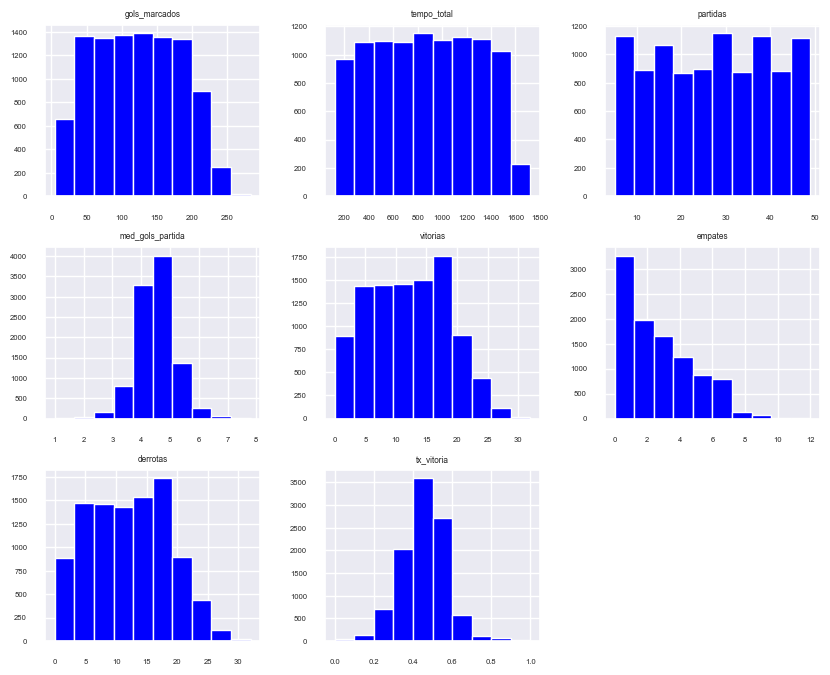

In [8]:
# PLOT DAS VARIAVEIS
sns.set(
    style='darkgrid', # ESTILO
    font_scale=0.5, # FONTE
    rc={'figure.figsize':(10,8)} # TAMANHO
)

graficos = jogadores.hist(color='blue')

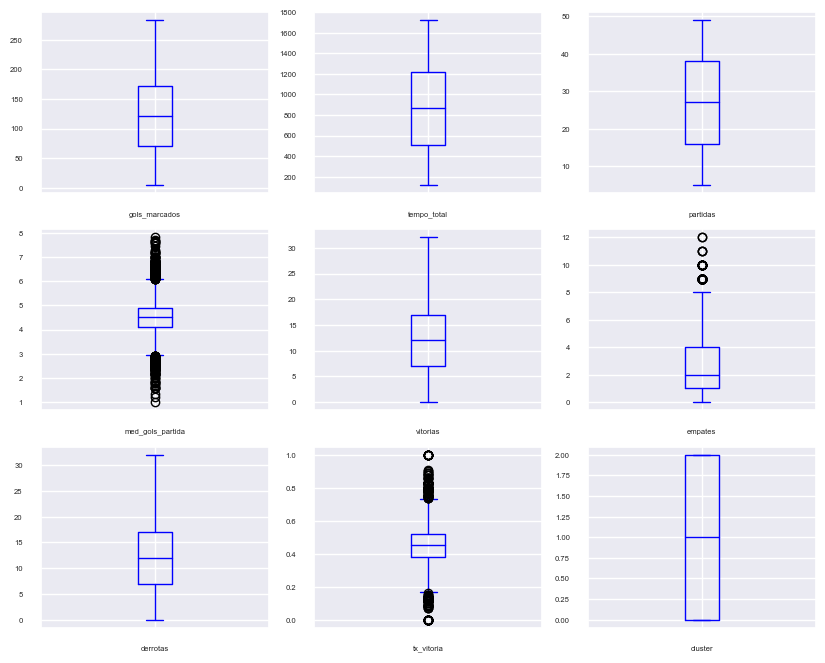

In [26]:
# BOXPLOT
boxplots = jogadores.plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, color='blue')

### ETAPAS DE CLUSTERIZAÇÃO

##### PRE-PROCESSAMENTO

In [10]:
### PRE-PROCESSAMENTO

#CRIANDO COPIA DF PRINCIPAL E SELECIONANDO VARIAVEIS
Base_cluster = jogadores.copy()
Base_cluster = Base_cluster[['gols_marcados','partidas','med_gols_partida','vitorias','tx_vitoria','empates','derrotas']]

#APLICANDO METODO 'STANDARDSCALER' PARA REESCALAR OS DADOS
Base_cluster = StandardScaler().fit_transform(Base_cluster)

##### PCA - REDUÇÃO DE DIMENSIONALIDADE

In [18]:
# PCA - REDUÇÃO DE DIMENSIONALIDADE
Base_cluster_pca = PCA(n_components=2).fit_transform(Base_cluster)

Base_cluster_pca = pd.DataFrame(Base_cluster_pca, columns=['PCA1','PCA2'])

fig = px.scatter(Base_cluster_pca, x="PCA1", y="PCA2", title='Grafico dados PCA')
fig.update_layout(width=800, height=450)
fig.show()

##### DEFINIÇÃO DE K (QTDD CLUSTERS) - TECNICA DE ELBOW COM YELLOWBRICK

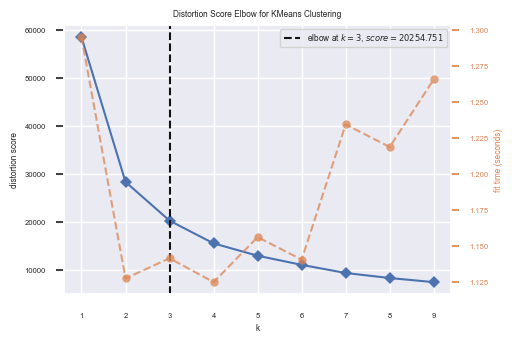

<Axes: title={'center': 'Distortion Score Elbow for KMeans Clustering'}, xlabel='k', ylabel='distortion score'>

In [12]:
algoritmo = KMeans()
visualizador = KElbowVisualizer(algoritmo, k=(1,10), size=(500, 350))
visualizador.fit(Base_cluster_pca)
visualizador.show()

##### CLUSTERIZAÇÃO COM K-MEANS

In [25]:
# NRO DE CLUSTER IDEAL ENCONTRADO NO GRAFICO DA ETAPA ANTERIOR
k = visualizador.elbow_value_ 

# CALCULANDO K-MEANS
kmeans = KMeans(n_clusters=k, init='random', n_init='auto').fit(Base_cluster_pca)
rotulos = kmeans.labels_
centroides = kmeans.cluster_centers_

tabela_clusters = pd.concat([Base_cluster_pca, pd.DataFrame({'CLUSTER':rotulos})], axis=1)

# PRINTANDO INFORMACOES DOS CLUSTERS
for c in range(k):
    cluster_membros=tabela_clusters[tabela_clusters['CLUSTER'] == c][:]
    print('Cluster_{} = {} membros'.format(c, len(cluster_membros)))
    print('-'* 35)

# CONCATENANDO ROTULOS DOS CLUSTER À BASE DE JOGADORES
jogadores['cluster'] = rotulos

fig = px.scatter(tabela_clusters, x="PCA1", y="PCA2", title='CLUSTERS', color="CLUSTER")
fig.update_layout(width=800, height=450)
fig.show()

Cluster_0 = 2699 membros
-----------------------------------
Cluster_1 = 4696 membros
-----------------------------------
Cluster_2 = 2605 membros
-----------------------------------


### PAIS DE MAIOR DESTAQUE NO JOGO

In [14]:
# COPIA DA BASE PRINCIPAL
Base1 = jogadores.copy()

# AGRUPANDO POR PAIS E CONTANDO QUANTOS JOGADORES HÁ EM CADA
Base1 =  pd.DataFrame(data = Base1.groupby(['country'],)['player_id'].count())
Base1.reset_index(inplace=True)

# AGRUPANDO POR PAIS E SOMANDO VARIAVEIS NUMERICAS
Col = ['gols_marcados','partidas','vitorias','tempo_total']
Base2 = pd.DataFrame(data = jogadores.groupby(['country'],)[Col].sum())
Base2.reset_index(inplace=True)

# COMBINANDO DFs PARA MANTER UMA UNICA BASE
Base = Base1.merge(Base2, how='left', left_on='country',right_on='country', copy=False)
Base.reset_index(inplace=True, drop=True)
Base.rename(columns={'player_id':'qtd_jogadores', 'country':'pais'}, inplace=True)

# DELETANDO DFs QUE NÃO SERÃO MAIS UTILIZADOS (LIBERAR MEMORIA)
del [Base1, Base2]

In [15]:
# ORDENACAO DA BASE PELAS VARIAVEIS 'VITORIAS', 'GOLS MARCADOS' E 'PARTIDAS'
Base.sort_values(by=['vitorias','gols_marcados','partidas'],inplace=True, ascending=False)

# TOP 5 PAISES
Base_final = Base[:5]
Base_final.reset_index(inplace=True, drop=True)

In [16]:
# PLOTAGEM DA TABELA PARA VALIDACAO
Base_final

,pais,qtd_jogadores,gols_marcados,partidas,vitorias,tempo_total
0,Australia,64,8883,1936,888.0,61663
1,Philippines,67,8749,1945,867.0,62009
2,Seychelles,65,8176,1815,817.0,58168
3,Lebanon,63,7926,1762,812.0,56611
4,Maldives,62,8092,1799,809.0,56893


In [17]:
# FUNÇÃO PARA PLOTAR GRAFICOS
def plot_grafico(base, x, y, cor, texto, titulo):
    base = base.sort_values(by=y, ascending=False)
    fig = px.bar(base, x=x, y=y, color=cor, text_auto=True, title=titulo, height=350, width=800)

    return fig

#CRIAÇÃO DOS GRAFICOS POR VARIAVEL ANALISADA
fig1 = plot_grafico(Base_final, 'pais', 'vitorias', 'vitorias', 'vitorias', 'QTD DE VITORIAS CONQUISTADAS POR PAÍS')
fig2 = plot_grafico(Base_final, 'pais', 'gols_marcados', 'gols_marcados', 'gols_marcados', 'TOTAL DE GOLS MARCADOS POR PAÍS')
fig3 = plot_grafico(Base_final, 'pais', 'partidas', 'partidas', 'partidas', 'QTD PARTIDAS DISPUTADAS POR PAÍS')
fig4 = plot_grafico(Base_final, 'pais', 'qtd_jogadores', 'qtd_jogadores', 'qtd_jogadores', 'QTD JOGADORES POR PAÍS')
fig5 = plot_grafico(Base_final, 'pais', 'tempo_total', 'tempo_total', 'tempo_total', 'TEMPO TOTAL JOGADO POR PAÍS (em minutos)')

fig1.show()
fig2.show()
fig3.show()
fig4.show()
fig5.show()
